## Probability Calibration using ML-Insights 
### On Example of Mortality Model Using MIMIC ICU Data*

This workbook is intended to demonstrate why probability calibration may be useful, and how to do it using the `prob_calibration_function` in the ML-Insights package.

We build a random forest model, demonstrate that using the vote percentage as a probability is not well-calibrated, and then show how to use an independent validation set and the `prob_calibration_function` to properly calibrate it so that accurate probabilities can be obtained.

*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016).
https://mimic.physionet.org


In [1]:
# "pip install ml_insights" in terminal if needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

In the next few cells, we load in some data, inspect it, select columns for our features and outcome (mortality) and fill in missing values with the median of that column.

In [2]:
# Load dataset derived from the MMIC database

lab_aug_df = pd.read_csv("data/lab_vital_icu_table.csv")

In [3]:
lab_aug_df.head(10)

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,NaN,NaN,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,NaN,NaN,21.0,21.0,NaN,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,NaN,NaN,23.0,23.0,NaN,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,NaN,NaN,33.0,35.0,NaN,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333
5,71,111944,211832,13.0,30.0,3.6,4.7,17.0,26.0,0.4,...,79.222208,13.0,25.0,17.130435,35.722224,37.833332,37.351852,99.0,100.0,99.862069
6,72,156857,239612,18.0,18.0,NaN,NaN,20.0,20.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78,100536,233150,9.0,9.0,2.7,3.1,26.0,26.0,0.8,...,121.129705,11.0,24.0,16.764706,36.333334,36.833335,36.577778,96.0,100.0,98.470588
8,88,123010,297289,13.0,18.0,NaN,NaN,19.0,26.0,NaN,...,91.884615,9.0,45.0,20.352941,35.722224,39.111112,37.810185,99.0,100.0,99.962963
9,95,160891,216431,13.0,17.0,NaN,NaN,23.0,26.0,NaN,...,93.952386,14.0,20.0,16.363636,35.722224,36.666667,36.305556,96.0,100.0,98.071429


In [4]:
X = lab_aug_df.loc[:,['aniongap_min', 'aniongap_max',
       'albumin_min', 'albumin_max', 'bicarbonate_min', 'bicarbonate_max',
       'bilirubin_min', 'bilirubin_max', 'creatinine_min', 'creatinine_max',
       'chloride_min', 'chloride_max', 
       'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max',
       'lactate_min', 'lactate_max', 'platelet_min', 'platelet_max',
       'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min',
       'inr_max', 'pt_min', 'pt_max', 'sodium_min', 'sodium_max', 'bun_min',
       'bun_max', 'wbc_min', 'wbc_max','sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean',
       'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min',
       'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'spo2_min', 'spo2_max', 'spo2_mean']]
y = lab_aug_df['hospital_expire_flag']

In [5]:
# Impute the median for in each column to replace NA's 

median_vec = [X.iloc[:,i].median() for i in range(len(X.columns))]

for i in range(len(X.columns)):
    X.iloc[:,i].fillna(median_vec[i],inplace=True)

Now we divide the data into training, validation, and test sets.  The training set will be used to fit the model, the validation set will be used to calibrate the probabilities, and the test set will be used to evaluate the performance.  We use a 60-20-20 split (achived by first doing 80/20 and then splitting the 80 by 75/25)

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=942)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=942)

Next, we fit a Random Forest model to our training data.  Then we use that model to predict "probabilities" on our validation and test sets.  

I use quotes on "probabilities" because these numbers, which are the percentage of trees that voted "yes" are better understood as mere scores.  A higher value should generally indicate a higher probability of mortality.  However, there is no reason to expect these to be well-calibrated probabilities.  The fact that, say, 60% of the trees voted "yes" on a particular case does not mean that that case has a 60% probability of mortality.

We will demonstrate this empirically later.

In [8]:
rfmodel1 = RandomForestClassifier(n_estimators = 500, class_weight='balanced_subsample', random_state=942 )
rfmodel1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=942, verbose=0, warm_start=False)

In [9]:
val_res = rfmodel1.predict_proba(X_val)[:,1]
test_res_uncalib = rfmodel1.predict_proba(X_test)[:,1]

What follows is histograms showing on the validation set (top row) and the test set (bottom row) the histogram of the random forest vote percentage for the negative cases (survivors, left side) and the positive cases (mortalities, right side).  As we would expect the distribution of mortalities is shifted to the right.  We store the "count vectors" so that we can calculate some empirical probabilites.  We use 20 equal size bins.

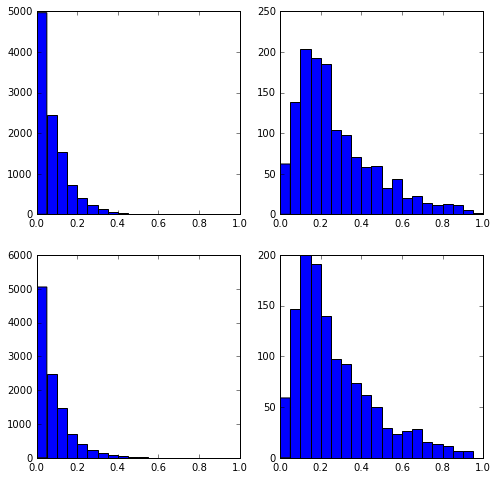

In [10]:
# Side by side histograms showing scores of positive vs negative cases

fig, axis = plt.subplots(2,2, figsize = (8,8))

ax=axis.flatten()
countvec0_val = ax[0].hist(val_res[np.where(y_val==0)],bins=20,range=[0,1]);
countvec1_val = ax[1].hist(val_res[np.where(y_val==1)],bins=20,range=[0,1]);
countvec0_test = ax[2].hist(test_res_uncalib[np.where(y_test==0)],bins=20,range=[0,1]);
countvec1_test = ax[3].hist(test_res_uncalib[np.where(y_test==1)],bins=20,range=[0,1]);

Next, we see the numerical counts in each bin for the validation set.

For example, in the first entry, we see that for the entries that had a vote percentage between 0 and .05, there were 4968 survivors, and 62 mortalities.  For those with a vote percentage between .05 and .10, there were 2450 survivors and 138 mortalities, and so on.  This allows us to calculate some empirical probabilities and visually see how well (or poorly) calibrated the vote percentage is.

In [11]:
list(zip(countvec0_val[0],countvec1_val[0]))

[(4968.0, 62.0),
 (2450.0, 138.0),
 (1543.0, 204.0),
 (722.0, 193.0),
 (403.0, 185.0),
 (223.0, 104.0),
 (130.0, 98.0),
 (57.0, 70.0),
 (44.0, 58.0),
 (19.0, 59.0),
 (14.0, 33.0),
 (12.0, 44.0),
 (6.0, 20.0),
 (1.0, 22.0),
 (3.0, 14.0),
 (0.0, 12.0),
 (2.0, 13.0),
 (0.0, 12.0),
 (0.0, 5.0),
 (0.0, 2.0)]

Using the counts above, we can calculate empirical probabilities for each bin.  Below, we can see the endpoints of each bin and the empirical probability of mortality for entries in that bin.  So for example, for entries with a vote percentage between .45 and .5, we can see that the empirical probability of mortality was .756 (59/78), which suggests that the vote percentage is not a well-calibrated probability.

In [12]:
emp_prob_vec_val = countvec1_val[0]/(countvec0_val[0]+countvec1_val[0])
list(zip([(i/20, (i+1)/20) for i in range(20)],emp_prob_vec_val))

[((0.0, 0.05), 0.012326043737574552),
 ((0.05, 0.1), 0.053323029366306028),
 ((0.1, 0.15), 0.11677160847166572),
 ((0.15, 0.2), 0.21092896174863388),
 ((0.2, 0.25), 0.31462585034013607),
 ((0.25, 0.3), 0.31804281345565749),
 ((0.3, 0.35), 0.42982456140350878),
 ((0.35, 0.4), 0.55118110236220474),
 ((0.4, 0.45), 0.56862745098039214),
 ((0.45, 0.5), 0.75641025641025639),
 ((0.5, 0.55), 0.7021276595744681),
 ((0.55, 0.6), 0.7857142857142857),
 ((0.6, 0.65), 0.76923076923076927),
 ((0.65, 0.7), 0.95652173913043481),
 ((0.7, 0.75), 0.82352941176470584),
 ((0.75, 0.8), 1.0),
 ((0.8, 0.85), 0.8666666666666667),
 ((0.85, 0.9), 1.0),
 ((0.9, 0.95), 1.0),
 ((0.95, 1.0), 1.0)]

To demonstrate this more visually, a well-calibrated probability should have the points falling (roughly) on the line x=y.  However, as we see in the plot below, most of the points lie above that line.  This suggest that (in particular for entries with vote percentage >.4) the true probability is considerably higher than the vote percentage.

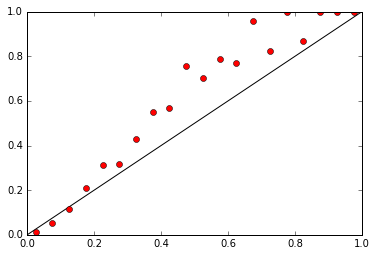

In [13]:
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(np.linspace(0.05,1,20)-.025,emp_prob_vec_val,'ro')

So how do we fix this?!  We can use the validation set to create a *calibration function*.  This function would map our uncalibrated score into a proper probability.  The ml-insights package has a function called `prob_calibration_function` which does just that.  Give it the scores and the true 0/1 values, and it will return a calibration function.  This calibration function can then be applied to the model output to yield a well-calibrated probability.

In [14]:
calibrate_rf = mli.prob_calibration_function(val_res, y_val)

Trying 241 values of C between 1e-06 and 1000000.0
Best value found C = [ 2511.88643151]


The function takes a little bit of time to run, primarily because it is doing cross-validation on the regularization parameter C (to balance fitting the current data with generalizing well).  There are additional settings on the function that can be applied to speed up this process, if desired.

As you can see below, the resulting function is a nice cubic function that fits the data well without over-fitting

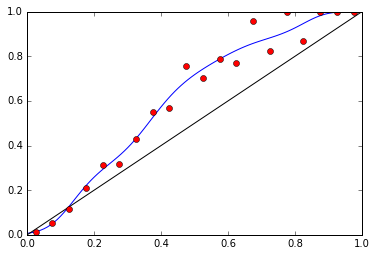

In [15]:
plt.plot(np.linspace(0,1,101),calibrate_rf(np.linspace(0,1,101)))
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(np.linspace(0.05,1,20)-.025,emp_prob_vec_val,'ro')

Now let's demonstrate that we actually have more accurate probabilities after calibration than we did before.  We will use the `log_loss` metric to determine which performs better on the test set, with or without calibration.

In [16]:
log_loss(y_test,test_res_uncalib)

0.25252730333409118

In [17]:
test_res_calib=calibrate_rf(test_res_uncalib)

In [18]:
log_loss(y_test,test_res_calib)

0.24456530517832997

In [19]:
brier_score_loss(y_test,test_res_uncalib)

0.073175005512208458

In [20]:
brier_score_loss(y_test,test_res_calib)

0.071994092057965781

As you can see, there is a significant improvement after calibration. (Lower loss is better)

This next plot shows the empirical probabilities of the test set data (that was not seen by the calibration process).

You can see, that the curve fits the data pretty well, though not as well as it fits the validation set (since it was trained on the validation set).

Note, the warning below is just eliminating the points where the counts in both bins was 0)

/Applications/anaconda/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


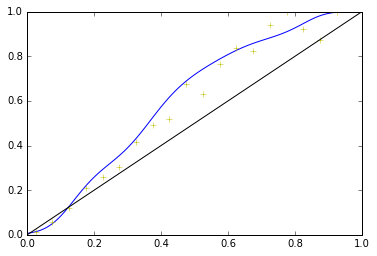

In [21]:
emp_prob_vec_test = countvec1_test[0]/(countvec0_test[0]+countvec1_test[0])
plt.plot(np.linspace(0,1,101),calibrate_rf(np.linspace(0,1,101)))
#plt.plot(np.linspace(.025,.975,20),emp_prob_vec_val,'ro')
plt.plot(np.linspace(.025,.975,20),emp_prob_vec_test,'y+')
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')

### Changing the Regularization Search

At the heart of the spline-fitting component of the calibration is a Penalized Logistic Regression, driven by the `LogisticRegressionCV` function in sklearn.  This function searches over a range of "C" values, where C is a parameter that controls the regularization (shrinkage) of the coefficients.

By default, `prob_calibration_function` searches over 241 values, logarithmically spaced between 10^-6 and 10^6. (In numpy language this is `reg_param_vec = 10**np.linspace(-6,6,241)`. However, you have the option to specify your own `reg_param_vec` vector of C values to try in the Cross-Validation.

If you recall previously, when we ran

`calibrate_rf = mli.prob_calibration_function(val_res, y_val)`

We got a message:


`Trying 241 values of C between 1e-06 and 1000000.0
Best value found C = [ 2511.88643151]`

If we wish to optimize more fully, we might want to try a range of points between 1000 and 5000 for C.
Below we show how to do this.

In [22]:
new_C_vec = np.linspace(2000,3000,51)
new_C_vec

array([ 2000.,  2020.,  2040.,  2060.,  2080.,  2100.,  2120.,  2140.,
        2160.,  2180.,  2200.,  2220.,  2240.,  2260.,  2280.,  2300.,
        2320.,  2340.,  2360.,  2380.,  2400.,  2420.,  2440.,  2460.,
        2480.,  2500.,  2520.,  2540.,  2560.,  2580.,  2600.,  2620.,
        2640.,  2660.,  2680.,  2700.,  2720.,  2740.,  2760.,  2780.,
        2800.,  2820.,  2840.,  2860.,  2880.,  2900.,  2920.,  2940.,
        2960.,  2980.,  3000.])

In [23]:
calibrate_rf_new = mli.prob_calibration_function(val_res, y_val,reg_param_vec=new_C_vec)

Trying 51 values of C between 2000.0 and 3000.0
Best value found C = [ 2060.]


Notice the function ran quicker this time, since we were only searching over 51 values instead of 241.  In general, if you want to save some time, you can specify a range with fewer points in the `reg_param_vec`

In [24]:
test_res_calib_new=calibrate_rf_new(test_res_uncalib)

In [25]:
log_loss(y_test,test_res_calib_new)

0.24464589789536564

We see that, in this case, the log_loss was little changed from our previous calibration.

## Existing Sklearn Calibration Functionality

Note, sklearn has a `CalibratedClassifierCV` function, but it does not seem to work as well.  Below is my attempt to use it and the results.  It is also possible I am not using it properly...

In [26]:
from sklearn.calibration import CalibratedClassifierCV

In [27]:
clf_isotonic = CalibratedClassifierCV(rfmodel1, method='isotonic',cv="prefit")
clf_isotonic.fit(X_val, y_val)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]


In [28]:
log_loss(y_test,prob_pos_isotonic)

0.26663934423877206

In [29]:
brier_score_loss(y_test,prob_pos_isotonic)

0.074458906233875938

The log loss and brier score loss is actually worse (higher) than the uncalibrated version, and considerably worse than the calibrated method using ml-insights

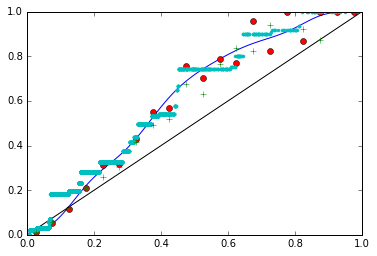

In [30]:
plt.plot(np.linspace(0,1,101),calibrate_rf(np.linspace(0,1,101)))
plt.plot(np.linspace(.025,.975,20),emp_prob_vec_val,'ro')
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(test_res_uncalib,prob_pos_isotonic,'c.')
plt.plot(np.linspace(.025,.975,20),emp_prob_vec_test,'g+')



From the plot above, it seems to give more of a "step function" calibration rather than a smooth, spline-like curve.  

In [31]:
clf_sigmoid = CalibratedClassifierCV(rfmodel1, method='sigmoid',cv="prefit")
clf_sigmoid.fit(X_val, y_val)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

In [32]:
log_loss(y_test,prob_pos_sigmoid)

0.25396992513972455

In [33]:
brier_score_loss(y_test,prob_pos_sigmoid)

0.073394487887474241

This time, the results are 

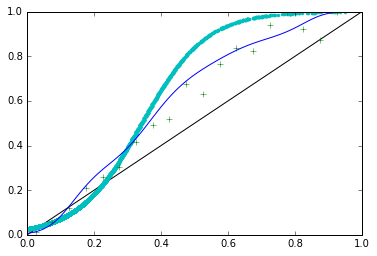

In [34]:
#plt.plot(np.linspace(.025,.975,20),emp_prob_vec_val,'ro')
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(test_res_uncalib,prob_pos_sigmoid,'c.')
plt.plot(np.linspace(.025,.975,20),emp_prob_vec_test,'g+')
plt.plot(np.linspace(0,1,101),calibrate_rf(np.linspace(0,1,101)))

Above, we see that the `sigmoid` option assumes a rather strict parametric form, and thus fits badly if the reality is not of that shape.
